In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

import numpy as np
import xarray as xr
import datetime

# import yaml
import tqdm
import torch
import pickle
import logging
import random

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count

from torch import nn

import torch

import torch.nn.functional as F

In [73]:
import matplotlib.pyplot as plt
from scipy.special import jv

In [4]:
dirP_str = os.path.join(os.environ['HOME'], 'Python/Python-Optics/Libraries')
if dirP_str not in sys.path:
    sys.path.append(dirP_str)
import FourierOpticsLib as FO

# # set path to local libraries
# dirP_str = '../../../library'
# if dirP_str not in sys.path:
#     sys.path.append(dirP_str)

In [28]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
    
print(f'Preparing to use device {device}')

Preparing to use device cuda:0


In [2]:
paths = {   'load_data':'/glade/scratch/mhayman/holodec/holodec-ml-data/hist-from-vae/',
            'save_data':'/glade/scratch/mhayman/holodec/holodec-ml-data/hist-from-vae/'}

In [3]:
files = {'data_file': 'training_1_25particles_gamma2D.nc', # _le4 #'histogram_training_data_5000count20200818T100751.nc',# 'histogram_training_data_5000count20200814T075733.nc',     # training data file
        'validation_file':'validation_1_25particles_gamma2D.nc',
        'test_file':'test_1_25particles_gamma2D.nc',}

# Single Particle

In [35]:
lam = 355e-9
z_max = 3e-2

# particle definitions
x_p = 130e-6
y_p = 87e-6
z_p = 5e-2
d_p = 45e-6

grid0 = FO.Coordinate_Grid((1.5e-3,5e-6))

In [36]:
E1 = FO.Efield(lam,grid0)

In [37]:
p1 = FO.Stop(d_p,z_p,grid0,offset=[x_p,y_p],invert=True)

In [38]:
p1.propagate(E1)
E1.propagate_to(z_max)

In [39]:
Iholo = np.abs(E1.field)**2
# Ih_fft = FO.OpticsFFT(Iholo)

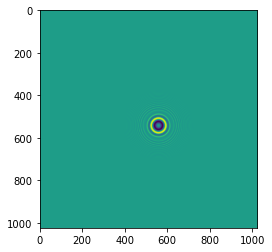

In [40]:
plt.figure()
plt.imshow(Iholo)

## Build Tiles

In [66]:
n_tile_x = 10
n_tile_y = 10
patch_size = 128
gridm2 = FO.Coordinate_Grid(((patch_size,patch_size),(grid0.dx,grid0.dy)),inputType='ccd')

In [67]:
x_patch_arr = np.round(np.linspace(0,grid0.Nx-patch_size,n_tile_x)).astype(int)
y_patch_arr = np.round(np.linspace(0,grid0.Ny-patch_size,n_tile_y)).astype(int)
print(f'{x_patch_arr.size} x patches of {patch_size} pixel width with {np.min(np.diff(x_patch_arr))} pixel spacing')
print(f'{y_patch_arr.size} y patches of {patch_size} pixel width with {np.min(np.diff(y_patch_arr))} pixel spacing')

10 x patches of 128 pixel width with 99 pixel spacing
10 y patches of 128 pixel width with 99 pixel spacing


In [82]:
# define Hann window if we want to use it
hann_window = np.cos(np.pi/2*gridm2.r/gridm2.x.max())
hann_window[np.where(gridm2.r > np.abs(gridm2.x.max()))] = 0

In [106]:
Ih_patch_lst = []
Ih_fft_patch_lst = []
patch_phase_adj_lst = []

for x_patch in x_patch_arr:
    for y_patch in y_patch_arr:
        # store the patches
        Ih_patch_lst.append(np.real(Iholo)[x_patch:(x_patch+patch_size),y_patch:(y_patch+patch_size)])
        # store the phase adjustment for the patch offset
        patch_phase_adj_lst.append(np.exp(1j*2*np.pi*(grid0.x[0,x_patch]*gridm2.fx + grid0.y[y_patch,0]*gridm2.fy)))
        # store the patch FFTs
        Ih_fft_patch_lst.append(FO.OpticsFFT(Ih_patch_lst[-1]*hann_window)*patch_phase_adj_lst[-1]) # 
        
          

        

In [107]:
grid0.x[0,x_patch]

0.0011250000000000001

In [108]:
Ih_patch_arr = np.stack(Ih_patch_lst,axis=2)
Ih_fft_patch_arr = np.stack(Ih_fft_patch_lst,axis=2)

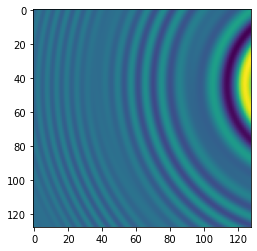

In [109]:
plt.figure()
plt.imshow(Ih_patch_arr[:,:,54])

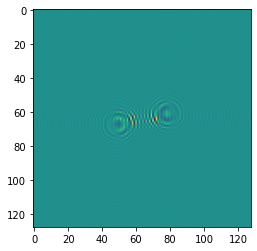

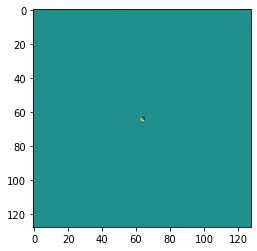

In [110]:
plt.figure()
plt.imshow(np.imag(FO.OpticsFFT(Ih_patch_arr[:,:,54])))
plt.figure()
plt.imshow(np.imag(Ih_fft_patch_arr[:,:,54]))

## Build the filter definitions

In [111]:
# set the range for evaluation of filters
x_filt_arr = np.arange(x_p-10e-6,x_p+10e-6,2e-6)
y_filt_arr = np.arange(y_p-10e-6,y_p+10e-6,2e-6)
z_filt_arr = np.arange(z_p-10e-6,z_p+10e-6,2e-6)
d_filt_arr = np.arange(d_p-10e-6,d_p+10e-6,2e-6)

In [112]:
# build z filters
z_filters_lst = []
for z in z_filt_arr:
    z_filters_lst.append(np.cos(2*np.pi*z/lam*np.sqrt(1-lam**2*gridm2.fr**2)))

In [113]:
# build x filters
x_filters_lst = []
for x in x_filt_arr:
    x_filters_lst.append(np.exp(1j*2*np.pi*gridm2.fx*x))

In [114]:
# build x filters
y_filters_lst = []
for y in y_filt_arr:
    y_filters_lst.append(np.exp(1j*2*np.pi*gridm2.fy*y))

In [115]:
d_filters_lst = []
for d in d_filt_arr:
    d_filters_lst.append(gridm2.fr**2*jv(1,2*np.pi*gridm2.fr*d/2)/d)

## Apply Filters

In [116]:
histogram_arr = np.zeros(len(x_filters_lst)*len(y_filters_lst)*len(z_filters_lst)*len(d_filters_lst))

In [117]:
filt_coords_lst = []
hist_idx = 0
for x_idx,xf in enumerate(x_filters_lst):
    for y_idx,yf in enumerate(y_filters_lst):
        for z_idx,zf in enumerate(z_filters_lst):
            for d_idx,df in enumerate(d_filters_lst):
                histogram_arr[hist_idx]+=np.sum(np.real(df[:,:,np.newaxis]*zf[:,:,np.newaxis]
                                              *yf[:,:,np.newaxis]*xf[:,:,np.newaxis]
                                              *Ih_fft_patch_arr))
                hist_idx+=1
                filt_coords_lst.append([x_idx,y_idx,z_idx,d_idx])